# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

#using TensorBoardLogger
using Logging

using BSON: @save, @load # save mode

┌ Warning: Replacing docs for `Main.Flyonic.Visualization.set_arrow :: Tuple{AbstractString}` in module `Main.Flyonic.Visualization`
└ @ Base.Docs docs/Docs.jl:240


In [2]:
R_TOL = 0.5
N_WAYPOINTS = 4
SLOW_MODE = true

true

In [3]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /Users/leonardoigler/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [4]:
# TensorBoard
#logger = TBLogger("tensorboard_PPO", tb_increment)

In [5]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

In [6]:
Δt = 0.025;

# Create Reinforcement Learning Environment

In [7]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # All possible actions the agent can take
    observation_space::Space{Vector{ClosedInterval{T}}} # All possible states that the agent can observe.
    state::Vector{T} # Current state
    action::ACT # next action the agent wants to apply in the environment.
    done::Bool # shows whether a terminal condition has been reached.
    t::T # time
    rng::R # random number generator

    name::String # for different naming of multible environoments
    visualization::Bool # activate visualisation (Faster computation without visualisation)
    realtime::Bool # visualization in "real-world" time (only for watching or filming).
    
    # Overall state of the environment. This does not correspond to the observation space of the agent but contains all states that describe the environment.
    x_W::Vector{T} # Position in World frame
    v_B::Vector{T} # Velocity in Body frame
    R_W::Matrix{T} # Rotation (matrix) in World frame
    ω_B::Vector{T} # Rotation velocity in Body frame
    wind_W::Vector{T} # Externel linear velocity acting on the drone
    Δt::T # Time step for physics simulation in seconds

    ###NEW###
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    norm_way::T
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
    projected_position::Vector{T}

    slow_mode::Bool
    ######
end

In [8]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "Crazyflie",
    visualization = true,
    realtime = true,
    kwargs... # let the function take an arbitrary number of keyword arguments
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.
    
    # final PWM Values for Crazyflie. The interval definition has no effect in the current implementation.
    action_space = Space(
        ClosedInterval{T}[
            0..1#0..65535, # motor 1
            0..1#0..65535, # motor 2
            0..1#0..65535, # motor 3
            0..1#0..65535, # motor 4
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            typemin(T)..typemax(T), # 1  World Vector UP x
            typemin(T)..typemax(T), # 2  World Vector UP y
            typemin(T)..typemax(T), # 3  World Vector UP z

            typemin(T)..typemax(T), # 4  World Vector FRONT x
            typemin(T)..typemax(T), # 5  World Vector FRONT y
            typemin(T)..typemax(T), # 6  World Vector FRONT z
            
            typemin(T)..typemax(T), # 7 Body velocity along x
            typemin(T)..typemax(T), # 8 Body velocity along y
            typemin(T)..typemax(T), # 9 Body velocity along z
            
            typemin(T)..typemax(T), # 10 Body rotational velocity around x
            typemin(T)..typemax(T), # 11 Body rotational velocity around y
            typemin(T)..typemax(T), # 12 Body rotational velocity around z
            
            ###NEW###
            typemin(T)..typemax(T), # 13 position error along x (next gate - current position)
            typemin(T)..typemax(T), # 14 position error along y (next gate - current position)
            typemin(T)..typemax(T), # 15 position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # 16 way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # 17 way to next next gate y (next next gate - next gate)
            typemin(T)..typemax(T), # 18 way to next next gate z (next next gate - next gate)
            ######
            ], 
    )

    ###NEW###
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints + 1) # trajectory with num_waypoints waypoints (+ start point), (with dummy points) 
    reached_goal = falses(num_waypoints)
    
    norm_way = 0.0 
    for i in 1:(num_waypoints - 1)
        norm_way += norm(waypoints[i] - waypoints[i + 1])
    end
    ######
    
    if visualization
        create_Crazyflie(name, actuators = true);
        visualize_waypoints(waypoints, 0.15)

        set_Crazyflie_actuators(name, [0.0; 0.0; 0.0; 0.0]);
        set_transform(name, [0.0; 0.0; 0.0] ,one(QuatRotation));
        set_arrow(string(name, "_vel"), color_vec=[0.0; 1.0; 0.0; 1.0]);
        transform_arrow(string(name, "_vel"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.05)
        set_arrow(string(name, "_vel_current"), color_vec=[1.0; 0.0; 0.0; 1.0]);
        transform_arrow(string(name, "_vel_current"), [0.0; 0.0; 0.0], [0.0; 0.0; 1.0], max_head_radius=0.02)                  
    end
    


    environment = VtolEnv(
        action_space,
        state_space,
        zeros(T, length(state_space)), # current state, needs to be extended.
        [0.25; 0.25; 0.25; 0.25],#rand(action_space),
        false, # episode done ?
        0.0, # time
        rng, # random number generator  

        name,
        visualization,
        realtime,

        zeros(T, 3), # x_W
        zeros(T, 3), # v_B
        Matrix(one(QuatRotation)), # Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        Δt, # Δt

        num_waypoints, # includig start point
        waypoints, 
        reached_goal,

        norm_way, # norm_way
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3), # projected_position

        SLOW_MODE # slow_mode

        )
    
    
    RLBase.reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [9]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/3d/RL_PPO.ipynb:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, norm_way::T, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T, projected_position::Vector{T}, slow_mode::Bool) where {A, T, ACT, R<:AbstractRNG} in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/3d/RL_PPO.ipynb:2

# Define the RL interface

In [10]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [11]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_position) > d_max
            s_gd = exp(-norm(x_W - projected_position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end;

In [12]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    
    if env.slow_mode
        v_min = 1.0 # min velocity
        v_max = 3.0 # max velocity
        d_max = 0.5 
    else
        v_min = 4.0 # min velocity
        v_max = 50.0 # max velocity
        d_max = 1.0 
    end


    s = scale_for_slowmode(true, v_min, v_max, d_max, env.x_W, env.projected_position, env.v_B)
    
    # TODO: test norming
    k_p = 5.0 * s #/ env.norm_way # factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt) / env.norm_way # factor for reached distance (overall) reward
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 50.0 # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    # factor for too high body rate penalty
    if env.slow_mode
        k_ω = 0.01
    else
        k_ω = 0.001
    end
    #norm_ω = norm(env.ω_B[3]) # penalty for body rate
    norm_ω = norm(env.ω_B) # penalty for body rate

    if env.x_W[3] < -2
        fall = 1
    else
        fall = 0
    end
    
    k_t = 0 # factor for time penalty
    k_d = 0 # factor for distance to next waypoint penalty
    r_d = 0 # penalty for distance to next waypoint
    if !env.slow_mode
        k_t = 0.001 
        k_d = 0.001
        #if env.current_point <= env.num_waypoints
        r_d = norm(env.x_W - env.waypoints[env.current_point]) / env.norm_way 
        #end
        k_s /= env.norm_way
        k_p /= env.norm_way
    end

    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω - fall # - k_t * env.t - k_d * r_d
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [13]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(one(QuatRotation)); # Identity matrix (no rotation)
    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];


    env.waypoints = generate_trajectory(env.num_waypoints + 1); # Dummy points
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints[1:env.num_waypoints], 0.15); 
    end
    
    norm_way = 0.0 
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end
    
    env.norm_way = norm_way
    env.progress = 0.0;
    env.progress_prev = 0.0;
        
 
    env.state = [env.R_W[1,3]; # 1  World Vector UP x
                 env.R_W[2,3]; # 2  World Vector UP y
                 env.R_W[3,3]; # 3  World Vector UP z

                 env.R_W[1,1]; # 4  World Vector FRONT x
                 env.R_W[2,1]; # 5  World Vector FRONT y
                 env.R_W[3,1]; # 6  World Vector FRONT z

                 env.v_B[1]; #  7  Body velocity along x
                 env.v_B[2]; #  8  Body velocity along y
                 env.v_B[3]; #  9  Body velocity along z

                 env.ω_B[1]; #  10  Body rotational velocity around x
                 env.ω_B[2]; #  11  Body rotational velocity around y
                 env.ω_B[3]; #  12  Body rotational velocity around z

                 env.waypoints[2][1] - env.x_W[1]; # 13 position error to next gate along x
                 env.waypoints[2][2] - env.x_W[2]; # 14 position error to next gate along z
                 env.waypoints[2][3] - env.x_W[3]; # 15 position error to next gate along z
                 
                 env.waypoints[3][1] - env.waypoints[2][1]; # 16 way to next next gate x
                 env.waypoints[3][2] - env.waypoints[2][2]; # 17 way to next next gate z  
                 env.waypoints[3][3] - env.waypoints[2][3]] # 18 way to next next gate z 
    
    
    env.t = 0.0; # time 0s
    env.action = [0.25; 0.25; 0.25; 0.25] # normalized
    #env.last_action = [0.255; 0.255; 0.255; 0.255] # normalized
    #env.current_action = [0.255; 0.255; 0.255; 0.255] # normalized

    env.done = false # reset termination

    env.projected_position = [0; 0; 0]
    
    if env.visualization
        # Visualize initial state
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05) 
        transform_arrow(string(env.name, "_vel_current"), env.x_W, [0.0; 0.0; 0.0], max_head_radius=0.05) 
    end
    
    nothing # return nothing
end;

In [14]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)


    # call the step on the environoment with the next action 
    _step!(env, a)
        
end

In [15]:
env = VtolEnv();

In [16]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/3d/RL_PPO.ipynb:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [17]:
function scale_actions(next_action)
    return next_action*22000.0
end

scale_actions (generic function with 1 method)

In [18]:
function _step!(env::VtolEnv, next_action)
    

    #env.last_action = copy(env.current_action)
    #env.current_action[1] = next_action[1]
    #env.current_action[2] = next_action[2]
    #env.current_action[3] = next_action[3]
    #env.current_action[4] = next_action[4]
    
    
    
    scaled_actions = scale_actions.(next_action) # between 0 and 1 for neual network
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = crazyflie_model(scaled_actions);
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, env.t = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, crazyflie_param)

    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_position = calculate_progress(env.waypoints, env.x_W)
    
    #env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    env.t += env.Δt


    if env.visualization
        set_transform(env.name, env.x_W,QuatRotation(env.R_W));
        set_Crazyflie_actuators(env.name, next_action[1:4])
        #transform_arrow(string(env.name, "_vel"), env.x_W, env.v_W_target, max_head_radius=0.05)               
        transform_arrow(string(env.name, "_vel_current"), env.x_W, env.R_W*env.v_B, max_head_radius=0.05) 
    
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end

    end
    
    
    #v_B_target = transpose(env.R_W)*env.v_W_target
    
    
    # State space
    env.state[1] = env.R_W[1,3] # 1  World Vector UP x
    env.state[2] = env.R_W[2,3] # 2  World Vector UP y
    env.state[3] = env.R_W[3,3] # 3  World Vector UP z

    env.state[4] = env.R_W[1,1] # 4  World Vector FRONT x
    env.state[5] = env.R_W[2,1] # 5  World Vector FRONT y
    env.state[6] = env.R_W[3,1] # 6  World Vector FRONT z
        
    env.state[7] = env.v_B[1] # 7  Body velocity along x
    env.state[8] = env.v_B[2] # 8  Body velocity along y
    env.state[9] = env.v_B[3] # 9  Body velocity along z

    env.state[10] = env.ω_B[1] # 10 Body rotational velocity around x
    env.state[11] = env.ω_B[2] # 11 Body rotational velocity around y
    env.state[12] = env.ω_B[3] # 12 Body rotational velocity around z

    env.state[13] = env.waypoints[env.current_point][1] - env.x_W[1] # 13 position error to next gate along x
    env.state[14] = env.waypoints[env.current_point][2] - env.x_W[2]; # 14 position error to next gate along z
    env.state[15] = env.waypoints[env.current_point][3] - env.x_W[3]; # 15 position error to next gate along z
                 
    if env.current_point <= env.num_waypoints
        env.state[16] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1] ; # 16 way to next next gate x (next next gate - next gate), dummy integriert
        env.state[17] = env.waypoints[env.current_point + 1][2] - env.waypoints[env.current_point][2]; # 17 way to next next gate y (next next gate - next gate), dummy integriert
        env.state[18] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # 18 way to next next gate z (next next gate - next gate), dummy integriert
    end

    
    
    # Termination criteria
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast_point 
        env.x_W[3] < -5.0 || # stop if body is below -5m
        #env.t > env.num_waypoints * 3.0 ||# stop after 3s per point
        norm(env.x_W - env.projected_position) > 5.0 || # too far off the path 
        env.reached_goal == trues(env.num_waypoints)

    nothing
end;

In [19]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total   Time
random policy with VtolEnv | 2000   2000  29.1s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.674525720425789e9, 1.674525749553458e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [20]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 1
    UPDATE_FREQ = 1024
        
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "cf_PPO$i") for i in 1:N_ENV
    ])



MultiThreadEnv(1 x VtolEnv)

In [21]:
# Define the function approximator
# TODO: change architecture eventually
ns, na = length(state(env[1])), length(action_space(env[1]))
approximator = ActorCritic(
            actor = GaussianNetwork(
                pre = Chain(
                Dense(ns, 256, tanh; initW = glorot_uniform(rng)),#
                Dense(256, 256, tanh; initW = glorot_uniform(rng)),
                ),
                μ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
                logσ = Chain(Dense(256, na; initW = glorot_uniform(rng))),
            ),
            critic = Chain(
                Dense(ns, 256, tanh; initW = glorot_uniform(rng)),
                Dense(256, 256, tanh; initW = glorot_uniform(rng)),
                Dense(256, 1; initW = glorot_uniform(rng)),
            ),
            optimizer = ADAM(1e-3),
        );

In [22]:
    agent = Agent( # A wrapper of an AbstractPolicy
         

        # AbstractPolicy: the policy to use
        policy = PPOPolicy(;
                    approximator = approximator |> cpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


In [23]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./", "cf_ppo_$t.bson")
    @save f model
    println("parameters at step $t saved to $f")
end

saveModel (generic function with 1 method)

In [24]:
test_env = VtolEnv(;name = "testVTOL");

In [25]:
function loadModel()
    f = joinpath("./", "model.bson")
    @load f model
    return model
end

loadModel (generic function with 1 method)

In [26]:
agent.policy.approximator = loadModel();

SystemError: SystemError: opening file "./model.bson": No such file or directory

In [27]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

visualize_validation = true; # TODO set as desired
episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = visualize_validation, realtime = visualize_validation);

In [28]:
# number of steps
steps_slow = 1_500_000 
steps_fast = 1_500_000
load_from_slow_step = 500_000 # TODO: choose slow model

steps = 0
if SLOW_MODE
    steps = steps_slow
else
    steps = steps_fast
end

1500000

In [29]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(steps),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   0%|                                         |  ETA: 28.63 days

Progress:   0%|                                         |  ETA: 1 days, 8:36:58

Progress:   0%|                                         |  ETA: 1 days, 3:35:35

Progress:   0%|                                         |  ETA: 1 days, 0:35:45

Progress:   0%|                                         |  ETA: 22:34:07

Progress:   0%|                                         |  ETA: 21:08:21

Progress:   0%|                                         |  ETA: 20:06:51

Progress:   0%|                                         |  ETA: 19:22:04

Progress:   0%|                                         |  ETA: 18:42:53

Progress:   0%|                                         |  ETA: 18:10:31

Progress:   0%|                                         |  ETA: 17:43:40

Progress:   0%|                                         |  ETA: 17:20:58

Progress:   0%|                                         |  ETA: 17:01:28

Progress:   0%|                                         |  ETA: 16:46:36

Progress:   0%|                                         |  ETA: 16:31:33

Progress:   0%|                                         |  ETA: 16:18:07

Progress:   0%|                                         |  ETA: 16:06:04

Progress:   0%|                                         |  ETA: 15:55:36

Progress:   0%|                                         |  ETA: 15:46:11

Progress:   0%|                                         |  ETA: 15:38:44

Progress:   0%|                                         |  ETA: 15:31:20

Progress:   0%|                                         |  ETA: 15:24:18

Progress:   0%|                                         |  ETA: 15:17:47

Progress:   0%|                                         |  ETA: 15:11:37

Progress:   0%|                                         |  ETA: 15:05:50

Progress:   0%|                                         |  ETA: 15:01:25

Progress:   0%|                                         |  ETA: 14:56:33

Progress:   0%|                                         |  ETA: 14:52:04

Progress:   0%|                                         |  ETA: 14:47:51

Progress:   0%|                                         |  ETA: 21:55:29

Progress:   0%|                                         |  ETA: 21:36:59

Progress:   0%|                                         |  ETA: 21:20:20

Progress:   0%|                                         |  ETA: 21:05:16

Progress:   0%|                                         |  ETA: 20:51:03

Progress:   0%|                                         |  ETA: 20:37:37

Progress:   0%|                                         |  ETA: 20:24:49

Progress:   0%|                                         |  ETA: 20:13:48

Progress:   0%|                                         |  ETA: 20:02:12

Progress:   0%|                                         |  ETA: 19:51:22

Progress:   0%|                                         |  ETA: 19:40:53

Progress:   0%|                                         |  ETA: 19:31:00

Progress:   0%|                                         |  ETA: 19:21:38

Progress:   0%|                                         |  ETA: 19:12:40

Progress:   0%|                                         |  ETA: 19:04:10

Progress:   0%|                                         |  ETA: 18:56:59

Progress:   0%|                                         |  ETA: 18:49:13

Progress:   0%|                                         |  ETA: 18:41:39

Progress:   0%|                                         |  ETA: 18:34:22

Progress:   0%|                                         |  ETA: 18:27:22

Progress:   0%|                                         |  ETA: 18:20:39

Progress:   0%|                                         |  ETA: 18:14:15

Progress:   0%|                                         |  ETA: 18:08:04

Progress:   0%|                                         |  ETA: 18:02:04

Progress:   0%|                                         |  ETA: 17:56:59

Progress:   0%|                                         |  ETA: 17:51:25

Progress:   0%|                                         |  ETA: 17:47:04

Progress:   0%|                                         |  ETA: 17:40:43

Progress:   0%|                                         |  ETA: 17:34:39

Progress:   0%|                                         |  ETA: 17:28:55

Progress:   0%|                                         |  ETA: 17:23:11

Progress:   0%|                                         |  ETA: 17:19:23

Progress:   0%|                                         |  ETA: 17:13:43

Progress:   0%|                                         |  ETA: 17:09:10

Progress:   0%|                                         |  ETA: 17:05:13

Progress:   0%|                                         |  ETA: 17:00:47

Progress:   0%|                                         |  ETA: 16:56:58

Progress:   0%|                                         |  ETA: 16:52:33

Progress:   0%|▏                                        |  ETA: 16:48:55

Progress:   0%|▏                                        |  ETA: 16:45:25

Progress:   0%|▏                                        |  ETA: 16:41:41

Progress:   0%|▏                                        |  ETA: 16:38:20

Progress:   0%|▏                                        |  ETA: 16:35:16

Progress:   0%|▏                                        |  ETA: 16:32:38

Progress:   0%|▏                                        |  ETA: 16:29:09

Progress:   0%|▏                                        |  ETA: 16:25:59

Progress:   0%|▏                                        |  ETA: 16:23:23

Progress:   0%|▏                                        |  ETA: 16:20:35

Progress:   0%|▏                                        |  ETA: 16:17:53

Progress:   0%|▏                                        |  ETA: 16:15:22

Progress:   0%|▏                                        |  ETA: 16:12:48

Progress:   0%|▏                                        |  ETA: 16:10:16

Progress:   0%|▏                                        |  ETA: 16:07:48

Progress:   0%|▏                                        |  ETA: 16:05:54

Progress:   0%|▏                                        |  ETA: 16:03:19

Progress:   0%|▏                                        |  ETA: 16:00:57

Progress:   0%|▏                                        |  ETA: 15:58:57

Progress:   0%|▏                                        |  ETA: 15:57:00

Progress:   0%|▏                                        |  ETA: 15:55:06

Progress:   0%|▏                                        |  ETA: 15:53:15

Progress:   0%|▏                                        |  ETA: 15:51:18

Progress:   0%|▏                                        |  ETA: 15:49:49

Progress:   0%|▏                                        |  ETA: 15:48:56

Progress:   0%|▏                                        |  ETA: 15:47:04

Progress:   0%|▏                                        |  ETA: 15:45:18

Progress:   0%|▏                                        |  ETA: 15:43:39

Progress:   0%|▏                                        |  ETA: 15:42:12

Progress:   0%|▏                                        |  ETA: 15:40:31

Progress:   0%|▏                                        |  ETA: 15:38:50

Progress:   0%|▏                                        |  ETA: 15:37:12

Progress:   0%|▏                                        |  ETA: 15:35:31

Progress:   0%|▏                                        |  ETA: 15:33:57

Progress:   0%|▏                                        |  ETA: 15:32:24

Progress:   0%|▏                                        |  ETA: 15:30:54

Progress:   0%|▏                                        |  ETA: 15:29:24

Progress:   0%|▏                                        |  ETA: 15:28:18

Progress:   0%|▏                                        |  ETA: 15:26:52

Progress:   0%|▏                                        |  ETA: 15:25:33

Progress:   0%|▏                                        |  ETA: 15:24:10

Progress:   0%|▏                                        |  ETA: 15:22:56

Progress:   0%|▏                                        |  ETA: 15:21:35

Progress:   0%|▏                                        |  ETA: 15:20:22

Progress:   0%|▏                                        |  ETA: 15:19:11

Progress:   0%|▏                                        |  ETA: 15:18:08

Progress:   0%|▏                                        |  ETA: 15:16:57

Progress:   0%|▏                                        |  ETA: 15:15:48

Progress:   0%|▏                                        |  ETA: 15:14:44

Progress:   0%|▏                                        |  ETA: 15:13:33

Progress:   0%|▏                                        |  ETA: 15:12:26

Progress:   0%|▏                                        |  ETA: 15:11:18

Progress:   0%|▏                                        |  ETA: 15:10:10

Progress:   0%|▏                                        |  ETA: 15:09:08

Progress:   0%|▏                                        |  ETA: 15:08:14

Progress:   0%|▏                                        |  ETA: 15:08:11

Progress:   0%|▏                                        |  ETA: 15:06:52

Progress:   0%|▏                                        |  ETA: 15:05:47

Progress:   0%|▏                                        |  ETA: 15:04:43

Progress:   0%|▏                                        |  ETA: 15:03:47

Progress:   0%|▏                                        |  ETA: 15:02:46

Progress:   0%|▏                                        |  ETA: 15:01:45

Progress:   0%|▏                                        |  ETA: 15:00:44

Progress:   0%|▏                                        |  ETA: 14:59:44

Progress:   0%|▏                                        |  ETA: 14:58:43

Progress:   0%|▏                                        |  ETA: 14:57:35

Progress:   0%|▏                                        |  ETA: 14:56:33

Progress:   0%|▏                                        |  ETA: 14:55:44

Progress:   0%|▏                                        |  ETA: 14:54:46

Progress:   0%|▏                                        |  ETA: 14:53:47

Progress:   0%|▏                                        |  ETA: 14:52:49

Progress:   0%|▏                                        |  ETA: 14:51:53

Progress:   0%|▏                                        |  ETA: 14:50:55

Progress:   0%|▏                                        |  ETA: 14:50:00

Progress:   0%|▏                                        |  ETA: 14:49:05

Progress:   0%|▏                                        |  ETA: 14:48:20

Progress:   0%|▏                                        |  ETA: 14:47:25

Progress:   0%|▏                                        |  ETA: 14:46:31

Progress:   0%|▏                                        |  ETA: 14:45:37

Progress:   0%|▏                                        |  ETA: 14:44:45

Progress:   0%|▏                                        |  ETA: 14:43:56

Progress:   0%|▏                                        |  ETA: 14:43:06

Progress:   0%|▏                                        |  ETA: 14:42:15

Progress:   0%|▏                                        |  ETA: 14:41:26

Progress:   0%|▏                                        |  ETA: 14:40:45

Progress:   0%|▏                                        |  ETA: 14:39:58

Progress:   0%|▏                                        |  ETA: 14:39:57

Progress:   0%|▏                                        |  ETA: 14:38:53

Progress:   0%|▏                                        |  ETA: 14:38:07

Progress:   0%|▏                                        |  ETA: 14:37:29

Progress:   0%|▏                                        |  ETA: 14:36:44

Progress:   0%|▏                                        |  ETA: 14:36:01

Progress:   0%|▏                                        |  ETA: 14:35:19

Progress:   0%|▏                                        |  ETA: 14:34:37

Progress:   0%|▏                                        |  ETA: 14:33:54

Progress:   0%|▏                                        |  ETA: 14:33:12

Progress:   0%|▏                                        |  ETA: 14:32:30

Progress:   0%|▏                                        |  ETA: 14:31:59

Progress:   0%|▏                                        |  ETA: 14:31:18

Progress:   0%|▏                                        |  ETA: 14:30:36

Progress:   0%|▏                                        |  ETA: 14:29:56

Progress:   0%|▏                                        |  ETA: 14:29:13

Progress:   0%|▏                                        |  ETA: 14:28:34

Progress:   0%|▏                                        |  ETA: 14:27:55

Progress:   0%|▏                                        |  ETA: 14:27:17

Progress:   0%|▏                                        |  ETA: 14:26:49

Progress:   0%|▏                                        |  ETA: 14:26:12

Progress:   0%|▏                                        |  ETA: 14:25:36

Progress:   0%|▏                                        |  ETA: 14:24:59

Progress:   0%|▏                                        |  ETA: 14:24:22

Progress:   0%|▏                                        |  ETA: 14:23:45

Progress:   0%|▏                                        |  ETA: 14:23:10

Progress:   0%|▏                                        |  ETA: 14:22:36

Progress:   0%|▏                                        |  ETA: 14:22:10

Progress:   0%|▏                                        |  ETA: 14:21:31

Progress:   0%|▏                                        |  ETA: 14:20:58

Progress:   0%|▏                                        |  ETA: 14:20:25

Progress:   0%|▏                                        |  ETA: 14:20:27

Progress:   0%|▏                                        |  ETA: 14:19:54

Progress:   0%|▏                                        |  ETA: 14:19:19

Progress:   0%|▏                                        |  ETA: 14:18:46

Progress:   0%|▏                                        |  ETA: 14:18:16

Progress:   0%|▏                                        |  ETA: 14:17:43

Progress:   0%|▏                                        |  ETA: 14:17:11

Progress:   0%|▏                                        |  ETA: 14:16:39

Progress:   0%|▏                                        |  ETA: 14:16:08

Progress:   0%|▏                                        |  ETA: 14:15:38

Progress:   0%|▏                                        |  ETA: 14:15:20

Progress:   0%|▏                                        |  ETA: 14:14:53

Progress:   0%|▏                                        |  ETA: 14:14:25

Progress:   0%|▏                                        |  ETA: 14:13:57

Progress:   0%|▏                                        |  ETA: 14:13:28

Progress:   0%|▏                                        |  ETA: 14:13:01

Progress:   0%|▏                                        |  ETA: 14:12:35

Progress:   0%|▏                                        |  ETA: 14:12:08

Progress:   0%|▏                                        |  ETA: 14:11:50

Progress:   0%|▏                                        |  ETA: 14:11:25

Progress:   0%|▏                                        |  ETA: 14:11:01

Progress:   0%|▏                                        |  ETA: 14:10:35

Progress:   0%|▎                                        |  ETA: 14:10:10

Progress:   0%|▎                                        |  ETA: 14:09:44

Progress:   0%|▎                                        |  ETA: 14:09:18

Progress:   0%|▎                                        |  ETA: 14:08:52

Progress:   0%|▎                                        |  ETA: 14:08:36

Progress:   0%|▎                                        |  ETA: 14:08:13

Progress:   0%|▎                                        |  ETA: 14:07:48

Progress:   0%|▎                                        |  ETA: 14:07:24

Progress:   0%|▎                                        |  ETA: 14:06:59

Progress:   0%|▎                                        |  ETA: 14:07:10

Progress:   0%|▎                                        |  ETA: 14:06:40

Progress:   0%|▎                                        |  ETA: 14:06:17

Progress:   0%|▎                                        |  ETA: 14:05:53

Progress:   0%|▎                                        |  ETA: 14:05:30

Progress:   0%|▎                                        |  ETA: 14:05:07

Progress:   0%|▎                                        |  ETA: 14:04:45

Progress:   0%|▎                                        |  ETA: 14:04:21

Progress:   0%|▎                                        |  ETA: 14:03:58

Progress:   0%|▎                                        |  ETA: 14:03:46

Progress:   1%|▎                                        |  ETA: 14:03:23

Progress:   1%|▎                                        |  ETA: 14:03:00

Progress:   1%|▎                                        |  ETA: 14:02:39

Progress:   1%|▎                                        |  ETA: 14:02:18

Progress:   1%|▎                                        |  ETA: 14:01:57

Progress:   1%|▎                                        |  ETA: 14:01:35

Progress:   1%|▎                                        |  ETA: 14:01:14

Progress:   1%|▎                                        |  ETA: 14:01:02

Progress:   1%|▎                                        |  ETA: 14:00:43

Progress:   1%|▎                                        |  ETA: 14:00:23

Progress:   1%|▎                                        |  ETA: 14:00:03

Progress:   1%|▎                                        |  ETA: 13:59:43

Progress:   1%|▎                                        |  ETA: 13:59:23

Progress:   1%|▎                                        |  ETA: 13:59:02

Progress:   1%|▎                                        |  ETA: 13:58:42

Progress:   1%|▎                                        |  ETA: 13:58:31

Progress:   1%|▎                                        |  ETA: 13:58:11

Progress:   1%|▎                                        |  ETA: 13:57:52

Progress:   1%|▎                                        |  ETA: 13:57:33

Progress:   1%|▎                                        |  ETA: 13:57:12

Progress:   1%|▎                                        |  ETA: 13:56:54

Progress:   1%|▎                                        |  ETA: 13:57:05

Progress:   1%|▎                                        |  ETA: 13:56:40

Progress:   1%|▎                                        |  ETA: 13:56:23

Progress:   1%|▎                                        |  ETA: 13:56:05

Progress:   1%|▎                                        |  ETA: 13:55:47

Progress:   1%|▎                                        |  ETA: 13:55:28

Progress:   1%|▎                                        |  ETA: 13:55:16

Progress:   1%|▎                                        |  ETA: 13:54:57

Progress:   1%|▎                                        |  ETA: 13:54:47

Progress:   1%|▎                                        |  ETA: 13:54:30

Progress:   1%|▎                                        |  ETA: 13:54:12

Progress:   1%|▎                                        |  ETA: 13:53:55

Progress:   1%|▎                                        |  ETA: 13:53:38

Progress:   1%|▎                                        |  ETA: 13:53:21

Progress:   1%|▎                                        |  ETA: 13:53:03

Progress:   1%|▎                                        |  ETA: 13:52:46

Progress:   1%|▎                                        |  ETA: 13:52:36

Progress:   1%|▎                                        |  ETA: 13:52:19

Progress:   1%|▎                                        |  ETA: 13:52:03

Progress:   1%|▎                                        |  ETA: 13:51:49

Progress:   1%|▎                                        |  ETA: 13:51:32

Progress:   1%|▎                                        |  ETA: 13:51:16

Progress:   1%|▎                                        |  ETA: 13:51:00

Progress:   1%|▎                                        |  ETA: 13:50:44

Progress:   1%|▎                                        |  ETA: 13:50:33

Progress:   1%|▎                                        |  ETA: 13:50:18

Progress:   1%|▎                                        |  ETA: 13:50:02

Progress:   1%|▎                                        |  ETA: 13:49:46

Progress:   1%|▎                                        |  ETA: 13:49:31

Progress:   1%|▎                                        |  ETA: 13:49:16

Progress:   1%|▎                                        |  ETA: 13:49:00

Progress:   1%|▎                                        |  ETA: 13:49:12

Progress:   1%|▎                                        |  ETA: 13:48:53

Progress:   1%|▎                                        |  ETA: 13:48:38

Progress:   1%|▎                                        |  ETA: 13:48:24

Progress:   1%|▎                                        |  ETA: 13:48:09

Progress:   1%|▎                                        |  ETA: 13:47:54

Progress:   1%|▎                                        |  ETA: 13:47:40

Progress:   1%|▎                                        |  ETA: 13:47:31

Progress:   1%|▎                                        |  ETA: 13:47:17

Progress:   1%|▎                                        |  ETA: 13:47:03

Progress:   1%|▎                                        |  ETA: 13:46:49

Progress:   1%|▎                                        |  ETA: 13:46:34

Progress:   1%|▎                                        |  ETA: 13:46:21

Progress:   1%|▎                                        |  ETA: 13:46:07

Progress:   1%|▎                                        |  ETA: 13:45:53

Progress:   1%|▎                                        |  ETA: 13:45:45

Progress:   1%|▎                                        |  ETA: 13:45:32

Progress:   1%|▎                                        |  ETA: 13:45:20

Progress:   1%|▎                                        |  ETA: 13:45:07

Progress:   1%|▎                                        |  ETA: 13:44:54

Progress:   1%|▎                                        |  ETA: 13:44:40

Progress:   1%|▎                                        |  ETA: 13:44:26

Progress:   1%|▎                                        |  ETA: 13:44:13

Progress:   1%|▎                                        |  ETA: 13:44:05

test reward at step 10000: -6.106500530874406


Progress:   1%|▎                                        |  ETA: 13:47:05

Progress:   1%|▎                                        |  ETA: 13:46:50

Progress:   1%|▎                                        |  ETA: 13:46:36

Progress:   1%|▎                                        |  ETA: 13:46:32

Progress:   1%|▎                                        |  ETA: 13:46:19

Progress:   1%|▎                                        |  ETA: 13:46:05

Progress:   1%|▎                                        |  ETA: 13:45:51

Progress:   1%|▎                                        |  ETA: 13:46:03

Progress:   1%|▎                                        |  ETA: 13:45:52

Progress:   1%|▎                                        |  ETA: 13:45:40

Progress:   1%|▎                                        |  ETA: 13:45:27

Progress:   1%|▎                                        |  ETA: 13:45:14

Progress:   1%|▎                                        |  ETA: 13:45:01

Progress:   1%|▎                                        |  ETA: 13:44:47

Progress:   1%|▎                                        |  ETA: 13:44:34

Progress:   1%|▎                                        |  ETA: 13:44:22

Progress:   1%|▎                                        |  ETA: 13:44:17

Progress:   1%|▎                                        |  ETA: 13:44:05

Progress:   1%|▎                                        |  ETA: 13:43:53

Progress:   1%|▎                                        |  ETA: 13:43:40

Progress:   1%|▎                                        |  ETA: 13:43:28

Progress:   1%|▎                                        |  ETA: 13:43:17

Progress:   1%|▎                                        |  ETA: 13:43:05

Progress:   1%|▎                                        |  ETA: 13:42:53

Progress:   1%|▎                                        |  ETA: 13:42:42

Progress:   1%|▎                                        |  ETA: 13:42:36

Progress:   1%|▎                                        |  ETA: 13:42:23

Progress:   1%|▎                                        |  ETA: 13:42:12

Progress:   1%|▎                                        |  ETA: 13:42:00

Progress:   1%|▎                                        |  ETA: 13:41:48

Progress:   1%|▎                                        |  ETA: 13:41:36

Progress:   1%|▎                                        |  ETA: 13:41:24

Progress:   1%|▎                                        |  ETA: 13:41:12

Progress:   1%|▎                                        |  ETA: 13:41:05

Progress:   1%|▎                                        |  ETA: 13:40:54

Progress:   1%|▎                                        |  ETA: 13:40:44

Progress:   1%|▎                                        |  ETA: 13:40:33

Progress:   1%|▎                                        |  ETA: 13:40:22

Progress:   1%|▎                                        |  ETA: 13:40:11

Progress:   1%|▎                                        |  ETA: 13:40:17

Progress:   1%|▎                                        |  ETA: 13:40:06

Progress:   1%|▎                                        |  ETA: 13:39:56

Progress:   1%|▎                                        |  ETA: 13:39:45

Progress:   1%|▎                                        |  ETA: 13:39:34

Progress:   1%|▍                                        |  ETA: 13:39:22

Progress:   1%|▍                                        |  ETA: 13:39:11

Progress:   1%|▍                                        |  ETA: 13:39:06

Progress:   1%|▍                                        |  ETA: 13:38:56

Progress:   1%|▍                                        |  ETA: 13:38:45

Progress:   1%|▍                                        |  ETA: 13:38:34

Progress:   1%|▍                                        |  ETA: 13:38:24

Progress:   1%|▍                                        |  ETA: 13:38:13

Progress:   1%|▍                                        |  ETA: 13:38:02

Progress:   1%|▍                                        |  ETA: 13:37:52

Progress:   1%|▍                                        |  ETA: 13:37:42

Progress:   1%|▍                                        |  ETA: 13:37:37

Progress:   1%|▍                                        |  ETA: 13:37:27

Progress:   1%|▍                                        |  ETA: 13:37:17

Progress:   1%|▍                                        |  ETA: 13:37:07

Progress:   1%|▍                                        |  ETA: 13:36:57

Progress:   1%|▍                                        |  ETA: 13:36:47

Progress:   1%|▍                                        |  ETA: 13:36:37

Progress:   1%|▍                                        |  ETA: 13:36:27

Progress:   1%|▍                                        |  ETA: 13:36:23

Progress:   1%|▍                                        |  ETA: 13:36:13

Progress:   1%|▍                                        |  ETA: 13:36:03

Progress:   1%|▍                                        |  ETA: 13:35:53

Progress:   1%|▍                                        |  ETA: 13:35:43

Progress:   1%|▍                                        |  ETA: 13:35:34

Progress:   1%|▍                                        |  ETA: 13:35:25

Progress:   1%|▍                                        |  ETA: 13:35:32

Progress:   1%|▍                                        |  ETA: 13:35:24

Progress:   1%|▍                                        |  ETA: 13:35:14

Progress:   1%|▍                                        |  ETA: 13:35:05

Progress:   1%|▍                                        |  ETA: 13:34:56

Progress:   1%|▍                                        |  ETA: 13:34:46

Progress:   1%|▍                                        |  ETA: 13:34:37

Progress:   1%|▍                                        |  ETA: 13:34:32

Progress:   1%|▍                                        |  ETA: 13:34:22

Progress:   1%|▍                                        |  ETA: 13:34:12

Progress:   1%|▍                                        |  ETA: 13:34:03

Progress:   1%|▍                                        |  ETA: 13:33:53

Progress:   1%|▍                                        |  ETA: 13:33:44

Progress:   1%|▍                                        |  ETA: 13:33:35

Progress:   1%|▍                                        |  ETA: 13:33:26

Progress:   1%|▍                                        |  ETA: 13:33:21

Progress:   1%|▍                                        |  ETA: 13:33:12

Progress:   1%|▍                                        |  ETA: 13:33:03

Progress:   1%|▍                                        |  ETA: 13:32:55

Progress:   1%|▍                                        |  ETA: 13:32:47

Progress:   1%|▍                                        |  ETA: 13:32:37

Progress:   1%|▍                                        |  ETA: 13:32:28

Progress:   1%|▍                                        |  ETA: 13:32:19

Progress:   1%|▍                                        |  ETA: 13:32:14

Progress:   1%|▍                                        |  ETA: 13:32:06

Progress:   1%|▍                                        |  ETA: 13:31:58

Progress:   1%|▍                                        |  ETA: 13:31:50

Progress:   1%|▍                                        |  ETA: 13:31:41

Progress:   1%|▍                                        |  ETA: 13:31:33

Progress:   1%|▍                                        |  ETA: 13:31:25

Progress:   1%|▍                                        |  ETA: 13:31:16

Progress:   1%|▍                                        |  ETA: 13:31:23

Progress:   1%|▍                                        |  ETA: 13:31:15

Progress:   1%|▍                                        |  ETA: 13:31:07

Progress:   1%|▍                                        |  ETA: 13:30:59

Progress:   1%|▍                                        |  ETA: 13:30:51

Progress:   1%|▍                                        |  ETA: 13:30:43

Progress:   1%|▍                                        |  ETA: 13:30:39

Progress:   1%|▍                                        |  ETA: 13:30:31

Progress:   1%|▍                                        |  ETA: 13:30:22

Progress:   1%|▍                                        |  ETA: 13:30:14

Progress:   1%|▍                                        |  ETA: 13:30:06

Progress:   1%|▍                                        |  ETA: 13:29:57

Progress:   1%|▍                                        |  ETA: 13:29:49

Progress:   1%|▍                                        |  ETA: 13:29:41

Progress:   1%|▍                                        |  ETA: 13:29:38

Progress:   1%|▍                                        |  ETA: 13:29:31

Progress:   1%|▍                                        |  ETA: 13:29:23

Progress:   1%|▍                                        |  ETA: 13:29:15

Progress:   1%|▍                                        |  ETA: 13:29:08

Progress:   1%|▍                                        |  ETA: 13:29:00

Progress:   1%|▍                                        |  ETA: 13:28:52

Progress:   1%|▍                                        |  ETA: 13:28:45

Progress:   1%|▍                                        |  ETA: 13:28:37

Progress:   1%|▍                                        |  ETA: 13:28:34

Progress:   1%|▍                                        |  ETA: 13:28:27

Progress:   1%|▍                                        |  ETA: 13:28:18

Progress:   1%|▍                                        |  ETA: 13:28:11

Progress:   1%|▍                                        |  ETA: 13:28:03

Progress:   1%|▍                                        |  ETA: 13:27:55

Progress:   1%|▍                                        |  ETA: 13:27:47

Progress:   1%|▍                                        |  ETA: 13:27:40

Progress:   1%|▍                                        |  ETA: 13:27:47

Progress:   1%|▍                                        |  ETA: 13:27:41

Progress:   1%|▍                                        |  ETA: 13:27:33

Progress:   1%|▍                                        |  ETA: 13:27:26

Progress:   1%|▍                                        |  ETA: 13:27:18

Progress:   1%|▍                                        |  ETA: 13:27:16

Progress:   1%|▍                                        |  ETA: 13:27:08

Progress:   1%|▍                                        |  ETA: 13:27:01

Progress:   1%|▍                                        |  ETA: 13:26:54

Progress:   1%|▍                                        |  ETA: 13:26:47

Progress:   1%|▍                                        |  ETA: 13:26:41

Progress:   1%|▍                                        |  ETA: 13:26:34

Progress:   1%|▍                                        |  ETA: 13:26:26

Progress:   1%|▍                                        |  ETA: 13:26:22

Progress:   1%|▍                                        |  ETA: 13:26:15

Progress:   1%|▍                                        |  ETA: 13:26:08

Progress:   1%|▍                                        |  ETA: 13:26:02

Progress:   1%|▍                                        |  ETA: 13:25:55

Progress:   1%|▍                                        |  ETA: 13:25:47

Progress:   1%|▍                                        |  ETA: 13:25:39

Progress:   1%|▍                                        |  ETA: 13:25:33

Progress:   1%|▍                                        |  ETA: 13:25:25

Progress:   1%|▍                                        |  ETA: 13:25:23

Progress:   1%|▍                                        |  ETA: 13:25:15

Progress:   1%|▍                                        |  ETA: 13:25:09

Progress:   1%|▍                                        |  ETA: 13:25:03

Progress:   1%|▍                                        |  ETA: 13:24:56

Progress:   1%|▍                                        |  ETA: 13:24:49

Progress:   1%|▍                                        |  ETA: 13:24:42

Progress:   1%|▍                                        |  ETA: 13:24:36

Progress:   1%|▍                                        |  ETA: 13:24:34

Progress:   1%|▍                                        |  ETA: 13:24:40

Progress:   1%|▍                                        |  ETA: 13:24:33

Progress:   1%|▍                                        |  ETA: 13:24:27

Progress:   1%|▍                                        |  ETA: 13:24:21

Progress:   1%|▍                                        |  ETA: 13:24:19

Progress:   1%|▍                                        |  ETA: 13:24:13

Progress:   1%|▍                                        |  ETA: 13:24:07

Progress:   1%|▍                                        |  ETA: 13:24:01

Progress:   1%|▍                                        |  ETA: 13:23:54

Progress:   1%|▍                                        |  ETA: 13:23:48

Progress:   1%|▍                                        |  ETA: 13:23:41

Progress:   1%|▍                                        |  ETA: 13:23:35

Progress:   1%|▍                                        |  ETA: 13:23:32

Progress:   1%|▍                                        |  ETA: 13:23:26

Progress:   1%|▍                                        |  ETA: 13:23:20

Progress:   1%|▍                                        |  ETA: 13:23:14

Progress:   1%|▍                                        |  ETA: 13:23:06

Progress:   1%|▍                                        |  ETA: 13:22:58

Progress:   1%|▍                                        |  ETA: 13:22:49

Progress:   1%|▌                                        |  ETA: 13:22:40

Progress:   1%|▌                                        |  ETA: 13:22:35

Progress:   1%|▌                                        |  ETA: 13:22:36

Progress:   1%|▌                                        |  ETA: 13:22:28

Progress:   1%|▌                                        |  ETA: 13:22:19

Progress:   1%|▌                                        |  ETA: 13:22:07

CompositeException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
      [1] poptask(W::Base.InvasiveLinkedListSynchronized{Task})
        @ Base ./task.jl:921
      [2] wait()
        @ Base ./task.jl:930
      [3] wait(c::Base.GenericCondition{Base.Threads.SpinLock})
        @ Base ./condition.jl:124
      [4] _trywait(t::Timer)
        @ Base ./asyncevent.jl:138
      [5] wait
        @ ./asyncevent.jl:155 [inlined]
      [6] sleep(sec::Float64)
        @ Base ./asyncevent.jl:240
      [7] _step!(env::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}, next_action::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true})
        @ Main ~/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/3d/RL_PPO.ipynb:46
      [8] (::VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG})(a::SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true})
        @ Main ~/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/3d/RL_PPO.ipynb:7
      [9] macro expansion
        @ ~/.julia/packages/ReinforcementLearningZoo/tvfq9/src/algorithms/policy_gradient/multi_thread_env.jl:91 [inlined]
     [10] (::ReinforcementLearningZoo.var"#130#131"{MultiThreadEnv{VtolEnv{Space{Vector{ClosedInterval{Float64}}}, Float64, Vector{Float64}, StableRNGs.LehmerRNG}, Matrix{Float64}, Vector{Float64}, Space{Matrix{ClosedInterval{Float64}}}, Space{Matrix{ClosedInterval{Float64}}}, Nothing}, Matrix{Float64}, Int64, Int64})()
        @ ReinforcementLearningZoo ./threadingconstructs.jl:258

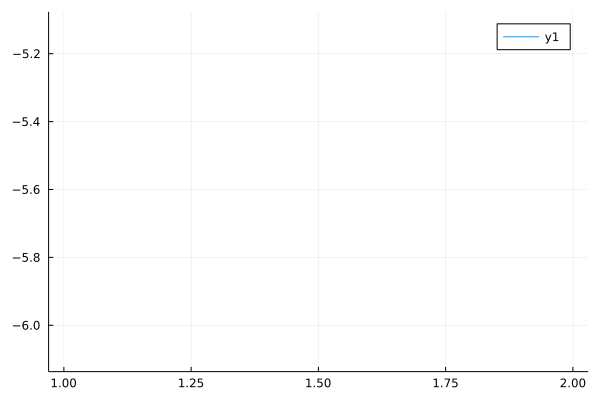

In [30]:
plot(episode_test_reward_hook.rewards)

In [31]:
plot(episode_test_step_hook.steps[1:2:end])

UndefVarError: UndefVarError: episode_test_step_hook not defined